# Tutorial for NIRCam Post-Pipeline Contrast Analyses Using spaceKLIP
---

In this notebook, you will explore the analysis of NIRCam coronagraphy data from the JWST ERS program on Direct Observations of Exoplanetary Systems [Program 1386](https://www.stsci.edu/jwst/science-execution/program-information?id=1386), with a focus on the exoplanet HIP 65426 b. This tutorial provides a detailed, step-by-step guide to performing contrast analysis using the spaceKLIP pipeline. By the end of this notebook, you will gain practical experience with tools and techniques essential for analyzing NIRCam coronagraphic data. This knowledge will equip you to apply these methods to similar datasets, enhancing your ability to extract meaningful results from high-contrast imaging observations.

<div class="alert alert-warning">
<b>Prerequisite:</b> This notebook assumes you have already run the "Tutorial for NIRCam Coronagraphy Reduction with spaceKLIP" notebook. The output files from that reduction must be present to be analyzed in this notebook.

</div>

<h1 style="font-size: 24px; font-weight: 550;">Table of Contents</h1>

* [1. Introduction](#Introduction)
* [2. Setup and Imports](#Setup-and-Imports)
* [3. Prepare for Contrast Calculations](#Prepare-for-Contrast-Calculations)
    * [3.1 Re-read Stage 3 Outputs into Database](#Re-read-Stage-3-Outputs-into-Database)
    * [3.2 Preparation: Stellar Photometry Model](#Preparation:-Stellar-Photometry-Model)
    * [3.3 Prior Knowledge About the Companion](#Prior-Knowledge-About-the-Companion)
    * [3.4 Set up Analysis Tools](#Set-up-Analysis-Tools)
* [4. Compute Raw Contrasts](#Compute-Raw-Contrasts)
* [5. Compute Calibrated Contrasts](#Compute-Calibrated-Contrasts)
* [6. Extract measurements of the planet](#Extract-measurements-of-the-planet)


---

## Introduction

High-contrast imaging (HCI) is a specialized technique used to observe faint astronomical sources, such as exoplanets or circumstellar disks, at small angular separations around a bright star. In this context, "contrast" is defined as the flux ratio (or brightness ratio) between the faint source and the star it orbits, typically expressed as $C=\frac{F_{\text{source}}}{F_{\text{star}}}$. When this ratio is small, the source is much fainter than the star, resulting in a "high-contrast" scenario that makes detection challenging. Conversely, a larger source-to-star ratio corresponds to "low-contrast" imaging, where the source is relatively brighter and easier to detect. Understanding and accurately measuring contrast is crucial for detecting faint objects and interpreting the significance of non-detections in high-contrast imaging systems. For a successful detection—or to confidently establish a non-detection—the imaging system must achieve a contrast that surpasses the detection threshold, known as the limiting contrast. This threshold is influenced by the system's sensitivity and resolution, which vary with the angular separation from the star.

Limiting contrast represents the faintest detectable brightness ratio at a given distance from the star. Typically, this contrast improves (i.e., the system can detect fainter objects) as the separation from the star increases. Closer to the star, only brighter sources are detectable, while fainter sources can be observed farther away. This relationship is depicted in a contrast curve, which illustrates the system's sensitivity as a function of angular separation from the star. Contrast curves are fundamental in assessing the performance of high-contrast imaging systems, guiding both the design of observational strategies and the interpretation of results. For a reference NIRCam contrast curve, you can explore the example provided [here](https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-high-contrast-imaging/jwst-high-contrast-imaging-supporting-technical-information/hci-contrast-considerations/hci-nircam-limiting-contrast#gsc.tab=0).

In this notebook, we will delve into the nuances and considerations surrounding these contrast curves and use them to interpret the extracted properties of the companion HIP 65426 b.

**ADDITIONAL RESOURCES**

* [HCI Overview](https://iopscience.iop.org/article/10.1088/1538-3873/aceb31#:~:text=HCI%20is%20a%20catchall%20term,the%20vicinity%20of%20bright%20stars.): A comprehensive introduction to High-Contrast Imaging.

---

## Setup and Imports

In [1]:
import os
import glob

import numpy as np
import astropy
import astropy.table

import matplotlib.pyplot as plt

import spaceKLIP

2024-09-18 12:17:37,877 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


Note that currently the import of `webbpsf_ext` has a side effect of configuring extra verbose logging. We're not interested in that logging text, so let's quiet it.

In [2]:
import webbpsf_ext
webbpsf_ext.setup_logging('WARN', verbose=False)

In [3]:
# Name the root directory where we will keep the data for this tutorial.
data_root = 'data_nircam_hd65426'

---

## Prepare for Contrast Calculations

### Re-read Stage 3 Outputs into Database 

Read in the output files produced in the NIRCam coronagraph data reduction notebook into a database.

For this example, we will restrict our analysis to just one filter. This approach is sufficient for demonstration purposes and is faster than running the analysis for all filters.

In [4]:
filt = 'F444W'  # Set to None to disable filter selection and load all filters.

In [5]:
# Define the directory containing the KLIP output files.
input_dir = os.path.join(data_root, 'klipsub')

# Get a sorted list of FITS files that match the filter and KLmodes pattern.
fitsfiles = sorted(glob.glob(os.path.join(input_dir, f"*{filt}*KLmodes-all.fits")))

# Initialize the SpaceKLIP database with the root data directory.
database = spaceKLIP.database.Database(output_dir=data_root)

# Read the JWST data from the FITS files into the database.
database.read_jwst_s3_data(fitsfiles)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
 TYPE   EXP_TYPE DATAMODL TELESCOP ... SUBSECTS    KLMODES     BUNIT  BLURFWHM
------ --------- -------- -------- ... -------- -------------- ------ --------
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan


---

### Preparation: Stellar Photometry Model

To accurately assess the contrast performance of our imaging system, we need a model of the target star. This model helps us compute the star’s flux in the observational filters and serves as a reference for evaluating our contrast measurements. The stellar photometry model can be provided in one of two formats:

1. **Photometry from Vizier**: Obtain a VOTable file from [Vizier](http://vizier.cds.unistra.fr) that contains the host star's photometry data. To create your own file, visit Vizier’s [Photometry Viewer](http://vizier.cds.unistra.fr/vizier/sed/) and enter your target star's details. Be cautious during this process, as nearby sources may introduce erroneous photometry measurements that could cause unexpected variations in the flux profile. To mitigate this, you may need to reduce the search radius or manually clean the data by removing incorrect points using the available checkboxes. After refining the data, click "Download Data" to save a VOTable file, which can be directly imported into spaceKLIP.

2. **Text File**: Alternatively, you can use a simple text file containing two columns: wavelength (in microns) and flux (in Jy). This file could be created by fitting a scaled version of a stellar atmosphere model to available photometry.

We provide examples of both types of files, courtesy of Aarynn Carter. Only one is needed; we offer both purely as examples.

In [6]:
star_photometry_vot = 'HIP65426.vot'  # VOTable.
star_photometry_txt = 'HIP65426A_sdf_phoenix_m+modbb_disk_r.txt'  # Text file.
star_spectral_type = 'A2V'  # Spectral type.

In [7]:
# Read in the VOTable version of the star photometry data.
vot_version = astropy.table.Table.read(star_photometry_vot)

# Convert frequency to wavelength (microns) for plotting.
vot_version["wavelength"] = (astropy.constants.c / vot_version["sed_freq"]).to(
    astropy.units.micron)

print("VOTable Version of Star Photometry Data:")
vot_version.to_pandas()  # For an easier to read output.

VOTable Version of Star Photometry Data:


,_RAJ2000,_DEJ2000,_tabname,_ID,sed_freq,sed_flux,sed_eflux,sed_filter,wavelength
0,201.150407,-51.504458,I/294A/ucac2bss,recno=18012,181750.0,1.9100,NaN,2MASS:H,1.649477
1,201.150407,-51.504458,I/294A/ucac2bss,recno=18012,241960.0,2.9300,NaN,2MASS:J,1.239017
2,201.150407,-51.504458,I/294A/ucac2bss,recno=18012,541430.0,5.7200,NaN,Johnson:V,0.553705
3,201.150407,-51.504458,I/294A/ucac2bss,recno=18012,563630.0,5.8600,NaN,HIP:VT,0.531896
4,201.150407,-51.504458,I/294A/ucac2bss,recno=18012,713280.0,5.5900,NaN,HIP:BT,0.420301
...,...,...,...,...,...,...,...,...,...
116,201.150407,-51.504458,J/MNRAS/471/770/table2,recno=59461,25934.0,0.0613,NaN,WISE:W3,11.559823
117,201.150407,-51.504458,J/MNRAS/471/770/table2,recno=59461,65172.0,0.3290,NaN,WISE:W2,4.600019
118,201.150407,-51.504458,J/MNRAS/471/770/table2,recno=59461,89490.0,0.6040,NaN,WISE:W1,3.350011
119,201.150407,-51.504458,J/MNRAS/471/770/table2,recno=59461,499420.0,5.9800,NaN,Subaru/Suprime:IA598,0.600281


In [8]:
# Read in the TXT version of the star photometry data.
txt_version = astropy.table.Table.read(star_photometry_txt,
                                       format='ascii',
                                       names=['wavelength', 'flux'])

# Assign appropriate units to the columns.
txt_version.columns['wavelength'].unit = astropy.units.micron  # Wavelength in microns.
txt_version.columns['flux'].unit = astropy.units.Jansky        # Flux in Jansky.

# Display the first few rows of the table for verification.
print("TXT Version of Star Photometry Data:")
txt_version.to_pandas()

TXT Version of Star Photometry Data:


,wavelength,flux
0,0.050000,7.560330e-18
1,0.050250,9.133000e-18
2,0.050501,1.103193e-17
3,0.050754,1.311524e-17
4,0.051008,1.560921e-17
...,...,...
2444,9836.145339,6.711463e-08
2445,9885.326065,6.634882e-08
2446,9934.752696,6.561208e-08
2447,9984.426459,6.510193e-08


Let's plot the Stellar Photometry Model.

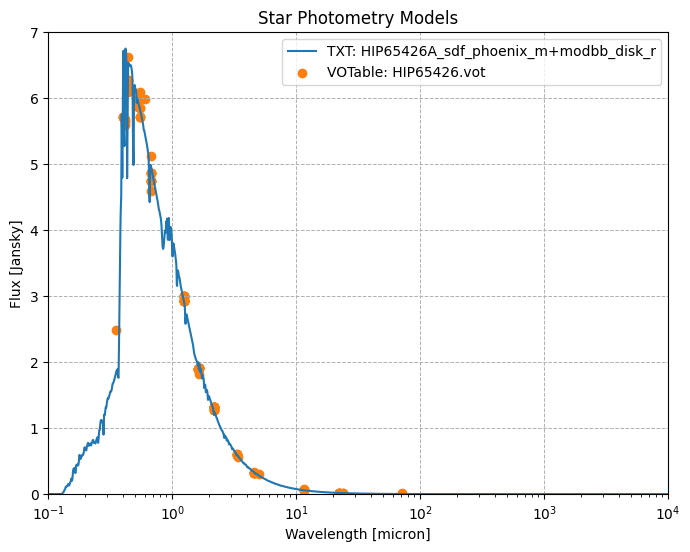

In [9]:
plt.figure(figsize=(8, 6))
plt.semilogx(
    txt_version["wavelength"],
    txt_version["flux"],
    label="TXT: HIP65426A_sdf_phoenix_m+modbb_disk_r",
    color="C0",
)
plt.scatter(
    vot_version["wavelength"],
    vot_version["sed_flux"],
    label="VOTable: HIP65426.vot",
    color="C1",
)

plt.xlabel("Wavelength [micron]")
plt.ylabel("Flux [Jansky]")
plt.legend(fontsize=10)

plt.xscale("log")
plt.xlim(0.1, 10**4)
plt.ylim(0, 7)
plt.grid(True, linestyle="--", linewidth=0.7)
plt.title("Star Photometry Models")

plt.show()

---

### Prior Knowledge About the Companion 

In this example, we focus on a known companion whose position and expected characteristics are already known. To ensure our contrast calculations accurately reflect the imaging system's performance, we need to mask out this known companion. This step is crucial because it prevents the known companion from affecting our contrast measurements, thereby providing a clearer picture of the system's capability to detect new, faint companions.

To locate the known companion, HIP 65426 b, we can use the coordinates provided by [whereistheplanet.com](http://whereistheplanet.com/) for the observation date of August 15, 2022. According to the data:

```
RA Offset = 416.618 +/- 0.045 mas
Dec Offset = -703.443 +/- 0.051 mas
Separation = 817.558 +/- 0.036 mas
PA = 149.364 +/- 0.004 deg
Reference: Blunt et al. 2023
```

The coordinates given specify the companion's position relative to the host star, with measurements in milli-arcseconds (mas) for the right ascension (RA) and declination (Dec), as well as the separation and position angle (PA) from the star.

Measuring the companion starts from an estimated contrast, which can be approximate and based on prior knowledge. 

In [10]:
comp_dra = 0.416  # arcsec
comp_ddec = -0.703  # arcsec
comp_est_contrast = 1e-4 # contrast ratio estimate

---

### Set up Analysis Tools

In this step, we set up the necessary tools for analyzing the data. This involves initializing the `AnalysisTools` class and providing it with the database of files that will be used in the analysis. The `AnalysisTools` class in spaceKLIP provides a suite of analysis tools, allowing you to compute raw and calibrated contrast curves, inject and recover synthetic companions, and extract companion parameters directly from high-contrast imaging data.

In [11]:
# Initialize the spaceKLIP contrast estimation class.
analysistools = spaceKLIP.analysistools.AnalysisTools(database)

---

## Compute Raw Contrasts

Raw contrast curves are essential for assessing the sensitivity of a high-contrast imaging system. These curves provide a preliminary measure of how well the system can detect faint objects relative to the brightness of the star it observes.

To compute a 'raw' contrast curve:

1. **Measure Image Noise**: Start by quantifying the noise in the image at various distances from the star. This involves calculating the standard deviation of pixel values within small annular regions (radial bins) centered at different separations from the star.

2. **Determine Contrast Threshold**: Using the star's photometric data (`starfile`) and spectral type (`spectral_type`), model its light to establish a baseline brightness and compare it against the observed data. Explicitly, we want to estimate the flux of the star in our observational bandpass. Many contrast curves presented in the literature are reported as "$5\sigma$" contrast curves. In this context, the "$5\sigma$" threshold corresponds to a brightness level that is five times the standard deviation of the noise in a given annular region. This threshold represents the faintest object that can be reliably detected above the noise. Other thresholds may also be used depending on the specific requirements of the analysis.

3. **Account for Coronagraph Mask Throughput**: Coronagraph throughput refers to the efficiency with which light passes through the coronagraph mask to the detector. It typically varies with both angular separation from the star and wavelength. To account for coronagraph throughput variations, the function `raw_contrast` applies a scaling factor to each location in the 2D image.

    * At smaller separations, the coronagraph blocks much of the starlight but also dims some light from faint companions. This reduced throughput lowers sensitivity, as less companion light reaches the detector, while residual starlight adds noise. As a result, the contrast curve steepens near the star, where faint objects are difficult to detect.
    * At larger separations, the coronagraph suppression decreases, allowing more light from faint companions to pass through. This improved throughput increases sensitivity, making it easier to detect faint objects.
    * Since throughput also varies with wavelength, different filters produce different contrast curves depending on the coronagraph performance at those wavelengths.

It is important to note that the raw contrast curve provides an initial estimate of sensitivity but does not fully capture the true performance of the imaging system. This is because the raw contrast curve does not correct for post-processing effects, such as those that may alter the flux of astronomical sources. To obtain a more accurate measure of sensitivity, we will compute a calibrated contrast curve in the subsequent section.

The calculation of raw contrast curves iterates over all filters and datasets present in the database. If you have applied multiple reduction strategies—such as Angular Differential Imaging (ADI), Reference Differential Imaging (RDI), or combinations like ADI+RDI, or varied the number of KL modes or annuli for optimization—the raw contrast calculation will be performed separately for each strategy or configuration.

[spaceKLIP.analysistools:INFO] Copying starfile HIP65426A_sdf_phoenix_m+modbb_disk_r.txt to data_nircam_hd65426/rawcon/HIP65426A_sdf_phoenix_m+modbb_disk_r.txt
[spaceKLIP.analysistools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_hd65426/klipsub/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.psf:INFO]   --> Generating WebbPSF model
[spaceKLIP.analysistools:INFO]   Masking out 1 known companions using provided parameters.
[spaceKLIP.analysistools:INFO]   Measuring raw contrast in annuli
[spaceKLIP.analysistools:INFO]   Measuring raw contrast for masked data
[spaceKLIP.analysistools:INFO]  Plot saved in data_nircam_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_masked.pdf


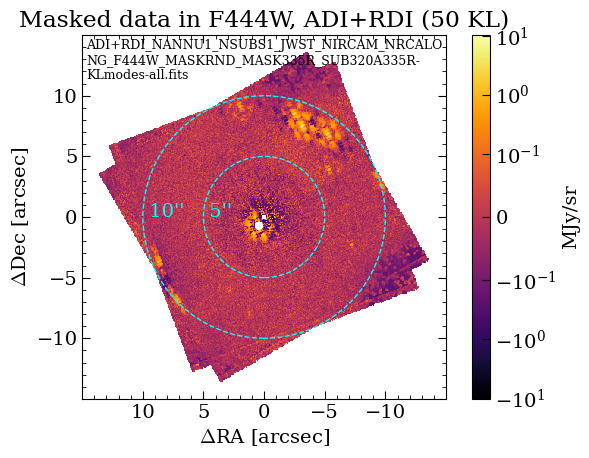

[spaceKLIP.analysistools:INFO]  Plot saved in data_nircam_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_rawcon.pdf


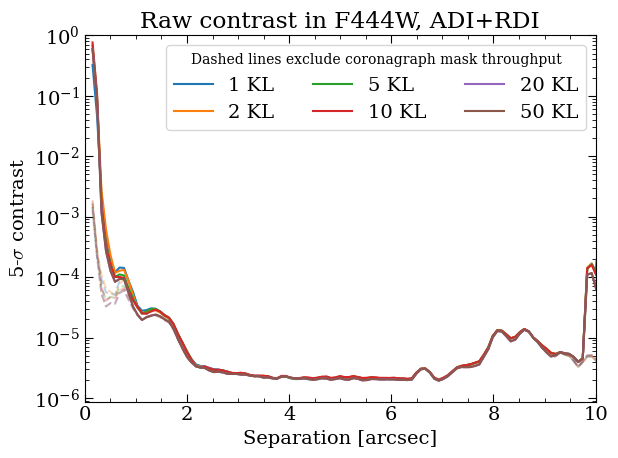

Contrast results and plots saved to data_nircam_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy, data_nircam_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy
[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_hd65426/klipsub/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.psf:INFO]   --> Generating WebbPSF model
[spaceKLIP.analysistools:INFO]   Masking out 1 known companions using provided parameters.
[spaceKLIP.analysistools:INFO]   Measuring raw contrast in annuli
[spaceKLIP.analysistools:INFO]   Measuring raw contrast for masked data
[spaceKLIP.analysistools:INFO]  Plot saved in data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_masked.pdf


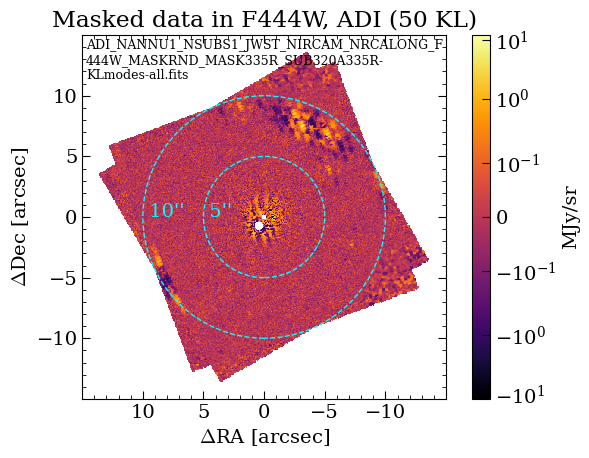

[spaceKLIP.analysistools:INFO]  Plot saved in data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_rawcon.pdf


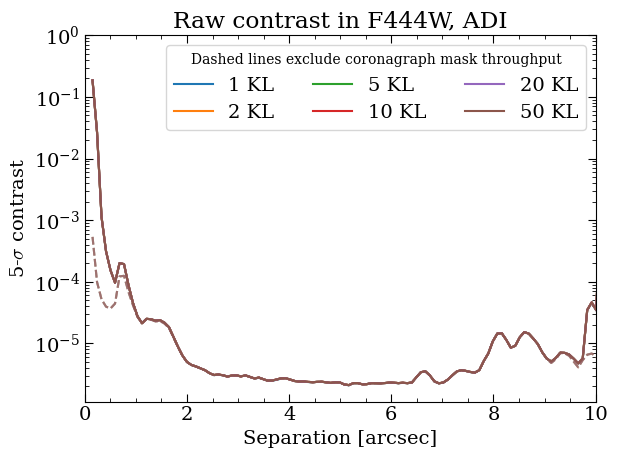

Contrast results and plots saved to data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy, data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy
[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_hd65426/klipsub/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.psf:INFO]   --> Generating WebbPSF model
[spaceKLIP.analysistools:INFO]   Masking out 1 known companions using provided parameters.
[spaceKLIP.analysistools:INFO]   Measuring raw contrast in annuli
[spaceKLIP.analysistools:INFO]   Measuring raw contrast for masked data
[spaceKLIP.analysistools:INFO]  Plot saved in data_nircam_hd65426/rawcon/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_masked.pdf


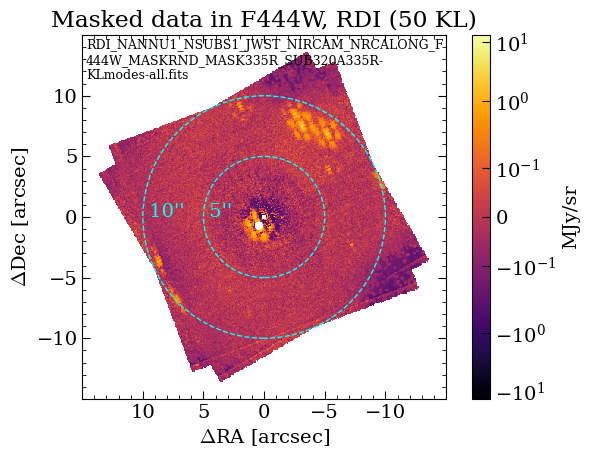

[spaceKLIP.analysistools:INFO]  Plot saved in data_nircam_hd65426/rawcon/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_rawcon.pdf


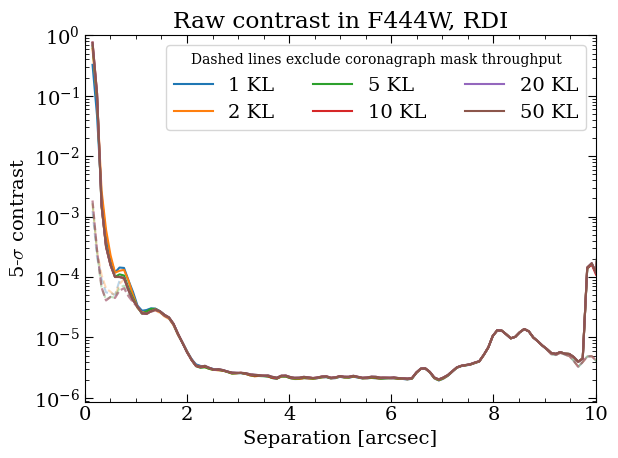

Contrast results and plots saved to data_nircam_hd65426/rawcon/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy, data_nircam_hd65426/rawcon/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy


In [12]:
# Compute raw contrast.
analysistools.raw_contrast(
    star_photometry_txt,  # Stellar photometry.
    spectral_type=star_spectral_type,  # Spectral type.
    # [RA offset (arcsec), Dec offset (arcsec), mask radius (lambda/D)].
    companions=[[comp_dra, comp_ddec, 2.]],
    subdir='rawcon')

The results of the raw contrast curve calculations are stored in the `rawcon` subdirectory within the main data directory. This directory contains several types of output files:

* **Masked Data & Contrast Curves**: These files include visual representations of the reduced images and plots of the contrast curves. The raw contrast curves are also saved in `.npy` format, which are NumPy data dump files.

The results should be automatically plotted when executing `raw_contrast`. To demonstrate how to access and visualize these results, we'll provide an example of how to read and plot one of these contrast curves. The results should be automatically plotted when executing `raw_contrast`.


Additionally, we plan to migrate to saving as astropy ECSV format text files, for easy use with `astropy.table`. 

In [13]:
# Optional: open the saved PDF files.
!open data_nircam_hd65426/rawcon/*pdf

In [14]:
!ls data_nircam_hd65426/rawcon/*npy

data_nircam_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy
data_nircam_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons_mask.npy
data_nircam_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy
data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy
data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons_mask.npy
data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy
data_nircam_hd65426/rawcon/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy
data_nircam_hd65426/rawcon/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons_mask.n

Text(0.5, 1.0, 'Raw Contrast in F444W')

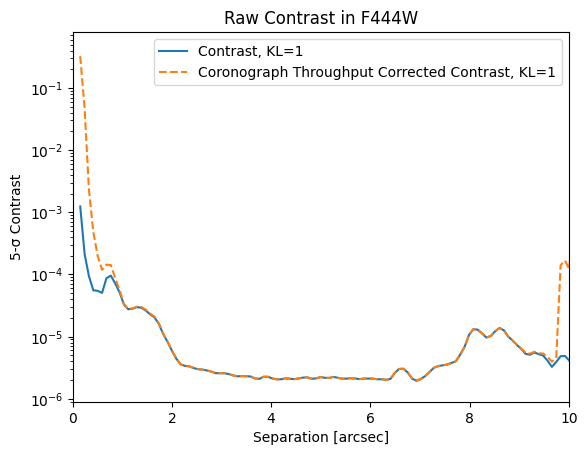

In [15]:
# Example of readining in and plotting contrast curve files.
base_path = 'data_nircam_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_'
suffix = 'NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_'

cons = np.load(f'{base_path}{suffix}cons.npy')
seps = np.load(f'{base_path}{suffix}seps.npy')
masks = np.load(f'{base_path}{suffix}cons_mask.npy')

plt.semilogy(seps[0], cons[0], label='Contrast, KL=1')
plt.semilogy(seps[0], masks[0], '--',
             label='Coronograph Throughput Corrected Contrast, KL=1')

plt.xlabel("Separation [arcsec]")
plt.ylabel("5-σ Contrast")
plt.legend()
plt.xlim(0,10)
plt.title("Raw Contrast in F444W")

The PDFs of the reduced images highlight separations at 5" and 10" to help correlate features in the contrast curves with those in the images. The contrast curve shows a steep drop at small separations due to high residual speckle noise near the star, where diffraction and instrumental artifacts dominate. At larger separations, the curve flattens as it reaches the background- and detector-limited regimes. The "wiggles" in the flat region are caused by the presence of background objects.


---

## Compute Calibrated Contrasts

The 'calibrated' contrast curve is an advanced metric that adjusts for various artifacts and inaccuracies inherent in high-contrast imaging. Unlike the raw contrast, which simply measures noise levels, the calibrated contrast takes into account the algorithm throughout, i.e., effects of over-subtraction and self-subtraction of companions during the PSF (point spread function) subtraction process. Throughput for high-contrast imaging algorithms like KLIP are typically low close to the star due to over-subtraction, where the algorithm aggressively removes residual starlight, unintentionally suppressing the companion's signal. This effect is most pronounced near the star, where starlight dominates. At greater distances, the KLIP throughput improves (approaches 1), allowing the companion's signal to remain largely unaffected by the subtraction process. Here, we can use the `calibrate_contrast` function to compute the calibrated contrast curves.

To compute the calibrated contrast, follow these steps:

1. **Prerequisite**: Ensure you have completed the raw contrast calculations first. The raw contrast serves as the foundation for calibration.

2. **Injection and Retrieval**: This process involves injecting simulated companion signals into the data at known separations (`injection_seps`) and position angles (`injection_pas`). The algorithm then retrieves these injected signals and applies scale factors to correct for distortions and inaccuracies introduced during PSF subtraction. The peak flux of the injected companions is determined by `injection_flux_sigma`, which is measured in sigma relative to the 1-sigma contrast at the injected separation.

3. **Calibration Application**: The retrieved scale factors are used to adjust the raw contrast curves, providing a more accurate representation of the system's true sensitivity. This calibration process is iterated across different PSF subtraction strategies (such as ADI, RDI, and ADI+RDI) and for varying numbers of KL modes.

Below, we highlight several additional configurable parameters

**Note**: The calibration process can take some time, depending on the number of injected companions and the subtraction strategies applied. During execution, progress bars will provide real-time updates on the status of the computation. To speed up the tutorial, we have specified a smaller number of separations and position angles (PAs) than is typically used. However, it is crucial to have enough separation sampling to understand how KLIP throughput varies with separation and sufficient PA sampling to accurately determine the median flux loss at each separation. The default values for these parameters offer a more typical use case.

[spaceKLIP.analysistools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.psf:INFO]   --> Generating WebbPSF model
[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_hd65426/klipsub/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 6 source positions suitable for injection.


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

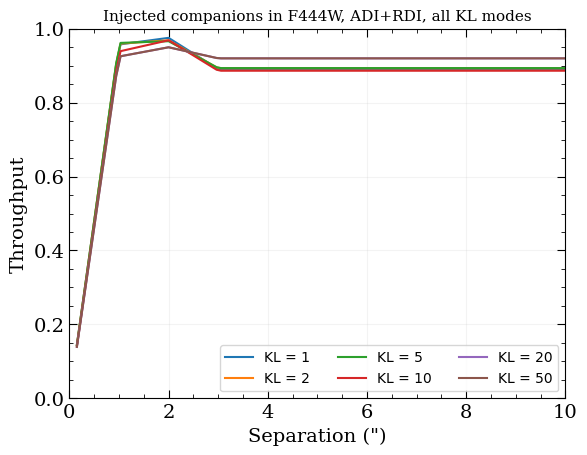

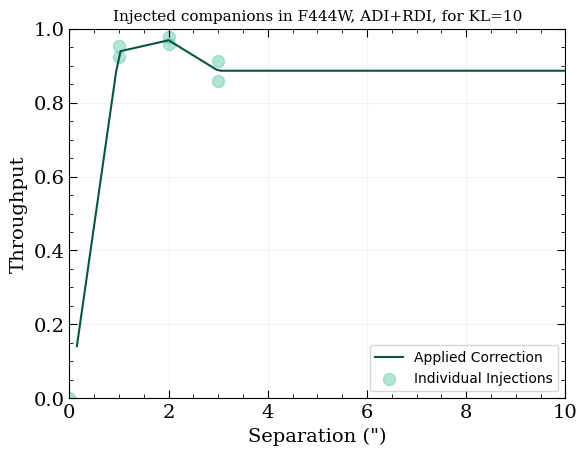

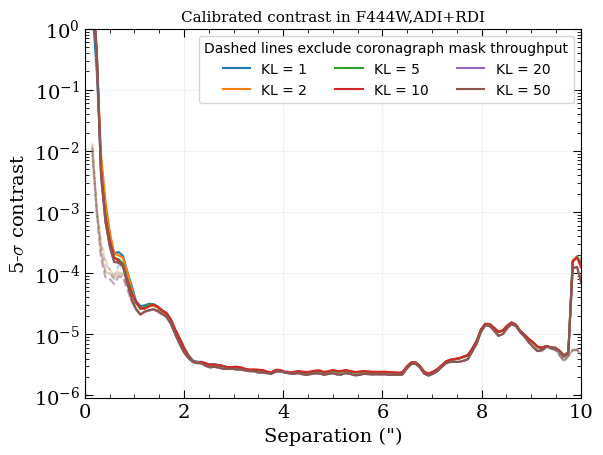

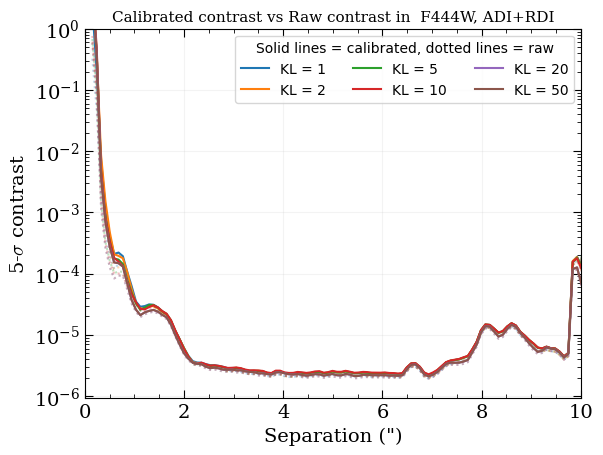

[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_hd65426/klipsub/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 6 source positions suitable for injection.


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

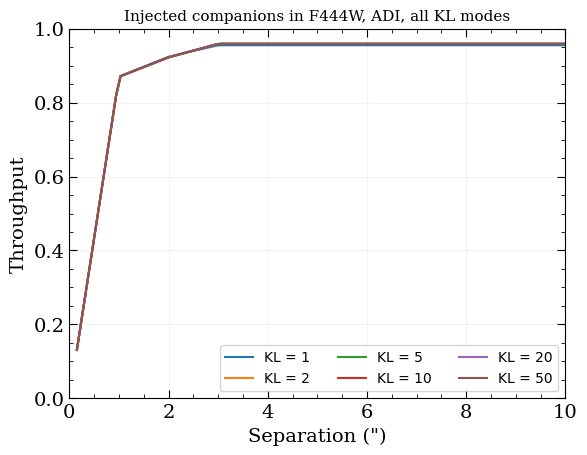

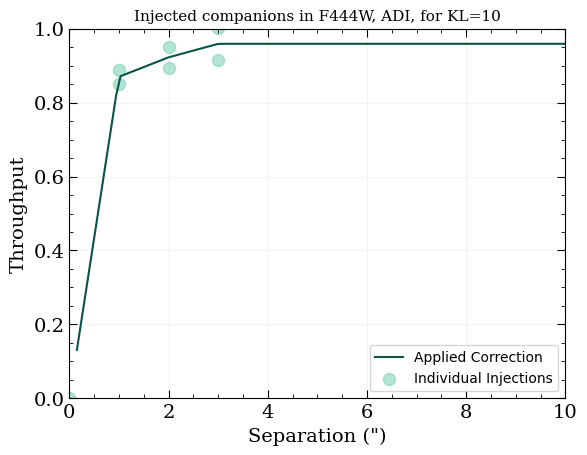

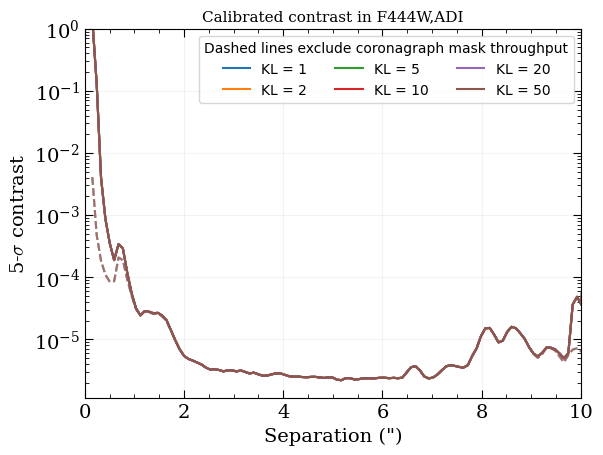

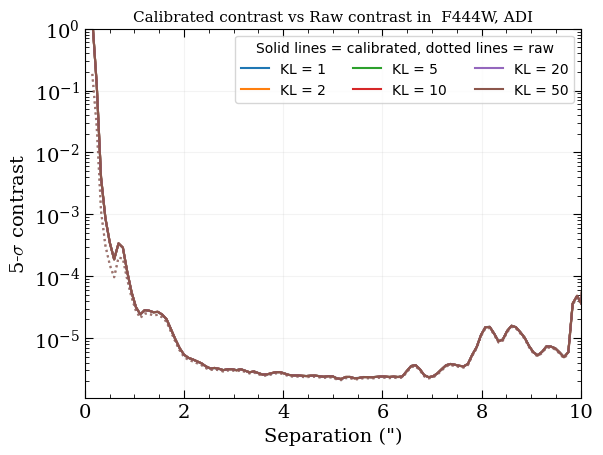

[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_hd65426/klipsub/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 6 source positions suitable for injection.


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

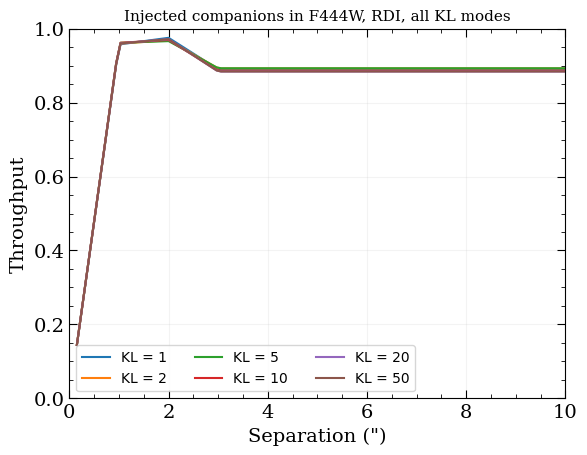

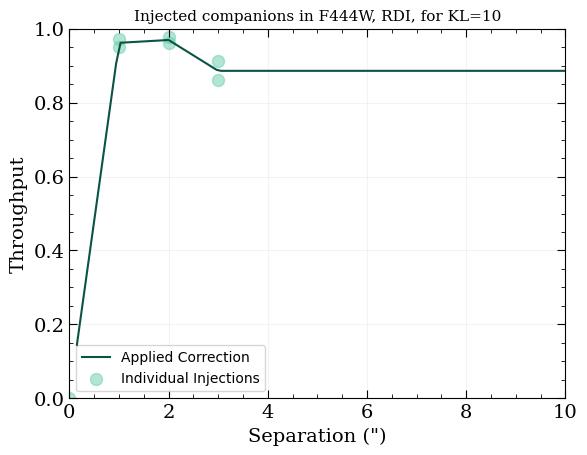

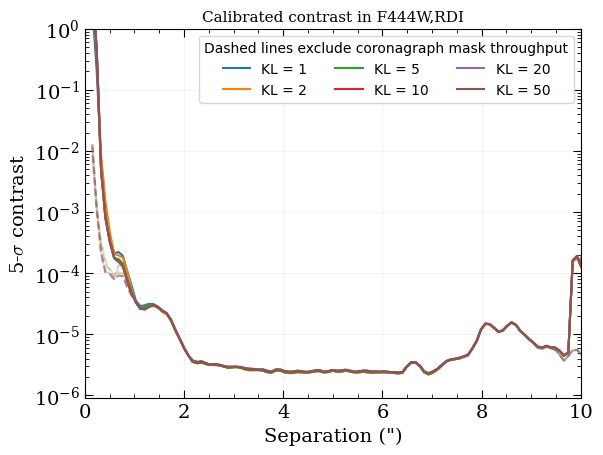

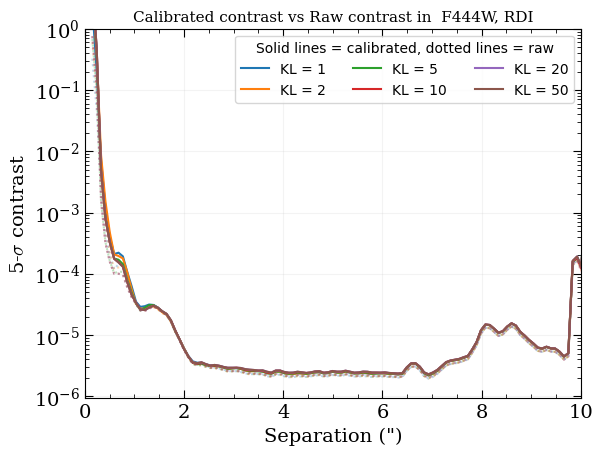

In [16]:
#Compute calibrated contrast.
analysistools.calibrate_contrast(
    rawcon_subdir='rawcon', # Directory raw contrasts are saved to.
    # [RA offset (arcsec), Dec offset (arcsec), mask radius (lambda/D)].
    companions=[[comp_dra, comp_ddec, 2.]],
    injection_seps=[1, 2, 3], # arcsec
    injection_pas=[45, 90],  # degrees
    injection_flux_sigma=20,
    # Spacing between injected companion, None = 1 companion per injection+recovery.
    multi_injection_spacing=None,
    use_saved=False,  # Useful for debugging / changing plots / sharing files.
    subdir = 'calcon')  # Save directory.


The results of the calibrated contrast curve calculations are stored in the `calcon` subdirectory within the main data directory. This directory contains the following output files:

* **Throughput & Calibrated Contrast Curves**: These files feature visual representations of throughput correction plots and calibrated contrast curves for each PSF subtraction strategy and KL mode. One plot specifically shows the median KL mode (10 in this case) with injected companions overlaid as blue dots, where each dot represents a different separation and PA angle. The calibrated contrast curves and injected companion data are also saved as `.npy` files.

The results are automatically plotted when executing `calibrate_contrast`. For an example of how to read and plot from the .npy files, refer to the demonstration above.

Again, we plan to migrate to saving as astropy ECSV format text files, for easy use with `astropy.table`. 

In [17]:
# Optional: open the saved PDF files.
!open data_nircam_hd65426/calcon/*pdf

In [18]:
!ls data_nircam_hd65426/calcon/*npy

data_nircam_hd65426/calcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cal_cons.npy
data_nircam_hd65426/calcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cal_maskcons.npy
data_nircam_hd65426/calcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cal_seps.npy
data_nircam_hd65426/calcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_injrec_inj_fluxes.npy
data_nircam_hd65426/calcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_injrec_pas.npy
data_nircam_hd65426/calcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_injrec_retr_fluxes.npy
data_nircam_hd65426/calcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_injrec_seps.npy
data_nircam_hd65426/calcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCAL

---

## Extract measurements of the planet

Using the `extract_companions` function, we will determine the best-fit parameters for each companion in the high-contrast imaging data. This includes properties such as RA and DEC offsets from the expected position and the companion's contrast. By comparing the observed data with a model of how the companion’s light should appear, this function adjusts the model parameters to best match the observed data, taking into account the effects of image processing techniques such as KLIP.

To extract measurements of the planet, follow these steps:

1. **Generate Initial Model PSF**: Create a forward model (FM) of the companion's PSF using initial guesses for offset position and contrast (defined by `companions`). The host star's spectral type (as defined by `spectral_type`) and a model for the stellar photometry (`starfile`) are used to simulate a realistic PSF. This step also requires an uncertainty for the stellar photometry in Vega magnitudes, parameterized `mstar_err`. This can be either a simple scalar estimate, like 0.05, or a dictionary giving uncertainty per JWST filter. 
    * **High-pass Filter:** Apply a high-pass filter to the model and KLIP subtracted data (`highpass`) to make small-scale signals (like the planet) more prominent.
    * **Remove Background:** Remove a constant background level from the KLIP-subtracted data before fitting the FM PSF (`remove_background`).
    * **Incorporate KLIP Effects**: Adjust the FM PSF to account for throughput losses caused by the KLIP algorithm (`use_fm_psf`). This step ensures that the model accurately reflects how much of the companion’s signal is retained after KLIP processing.
  
2. **Fit the Model to the Observed Data**: The FM PSF is initially placed at the guessed location in the observed image, and its parameters (such as position and brightness) are refined to minimize the difference between the FM and the actual data. The fitting process is defined by `fitmethod`, which can use techniques like Markov Chain Monte Carlo ('mcmc') or 'nested' sampling to explore parameter values and find the best fit. Additionally, the `fitkernel` parameter specifies the covariance function used in Gaussian process regression to model noise correlations during the fitting process.

3. **Iterative Refinement**: The fitting process is repeated, refining the FM PSF and companion parameters iteratively to achieve the best match between the model and the observed data.

4. **Calculate and Analyze Residuals:** Compute the differences between the final model and the observed data to assess the fit quality and identify any additional companions. If there are multiple companions to fit, toggle the `subtract` parameter to subtract each extracted companion from the dataset before fitting the next one.

Below, we highlight several additional configurable parameters.

Plots of the final model PSF, residuals, and best-fit parameter corner plots are saved and output during the execution of `extract_companions`.

In [19]:
# Values taken from model analysis of HIP 65426 photometry,
# provided by Aarynn Carter / Grant Kennedy.
mstar_err = {'F250M': 0.054,
             'F300M': 0.046,
             'F356M': 0.048,
             'F410M': 0.051,
             'F444W': 0.054,
             'F1140C': 0.038,
             'F1550C': 0.072}

[spaceKLIP.analysistools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.psf:INFO] Generating on-axis and off-axis PSFs...
[spaceKLIP.psf:INFO]   Done.
Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 723807.0352323258 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time

Closing threadpool
Writing KLIPed Images to directory /System/Volumes/Data/user/kglidic/spaceKLIP/docs/source/tutorials/data_nircam_hd65426/companions/KL50/C1/KLIP_FM
Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished


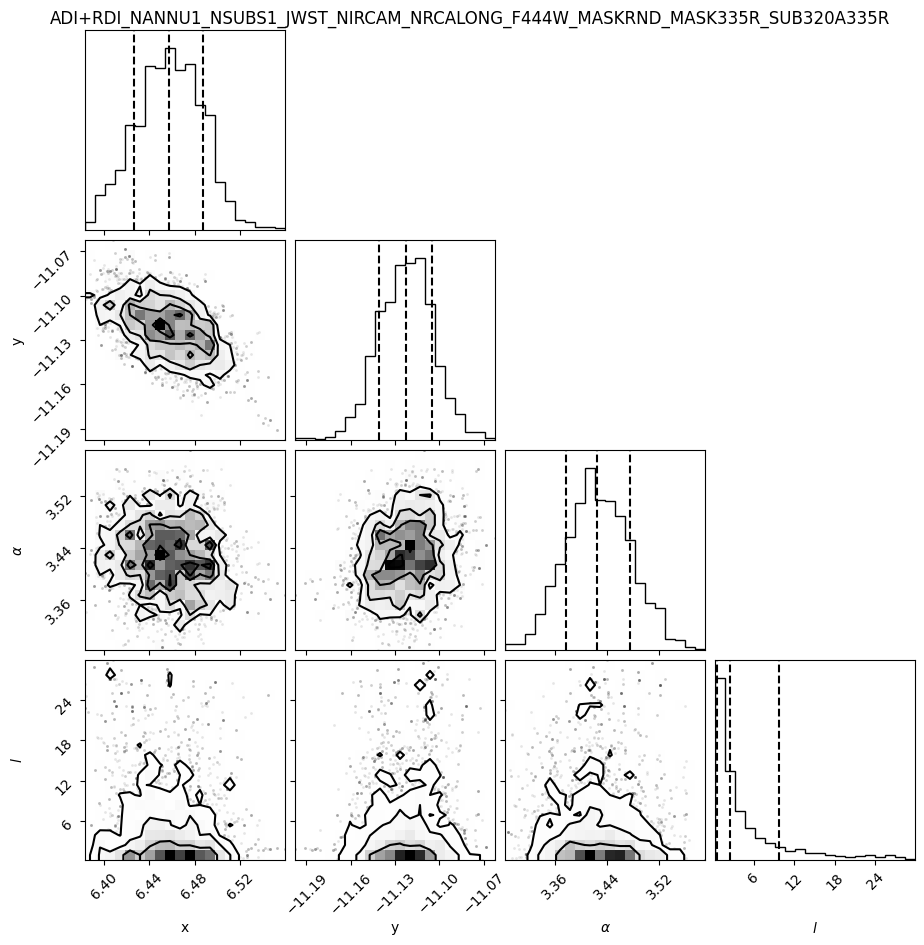

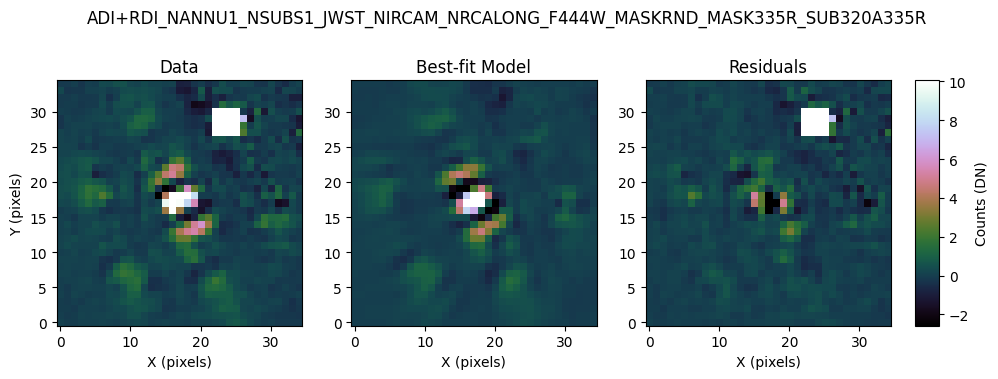

  0%|          | 0/1 [00:00<?, ?it/s]

Table saved to data_nircam_hd65426/companions/KL50/C1/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-results_c1.ecsv
[spaceKLIP.psf:INFO] Generating on-axis and off-axis PSFs...
[spaceKLIP.psf:INFO]   Done.
Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 723807.0352323258 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time

Closing threadpool
Writing KLIPed Images to directory /System/Volumes/Data/user/kglidic/spaceKLIP/docs/source/tutorials/data_nircam_hd65426/companions/KL50/C1/KLIP_FM
Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished


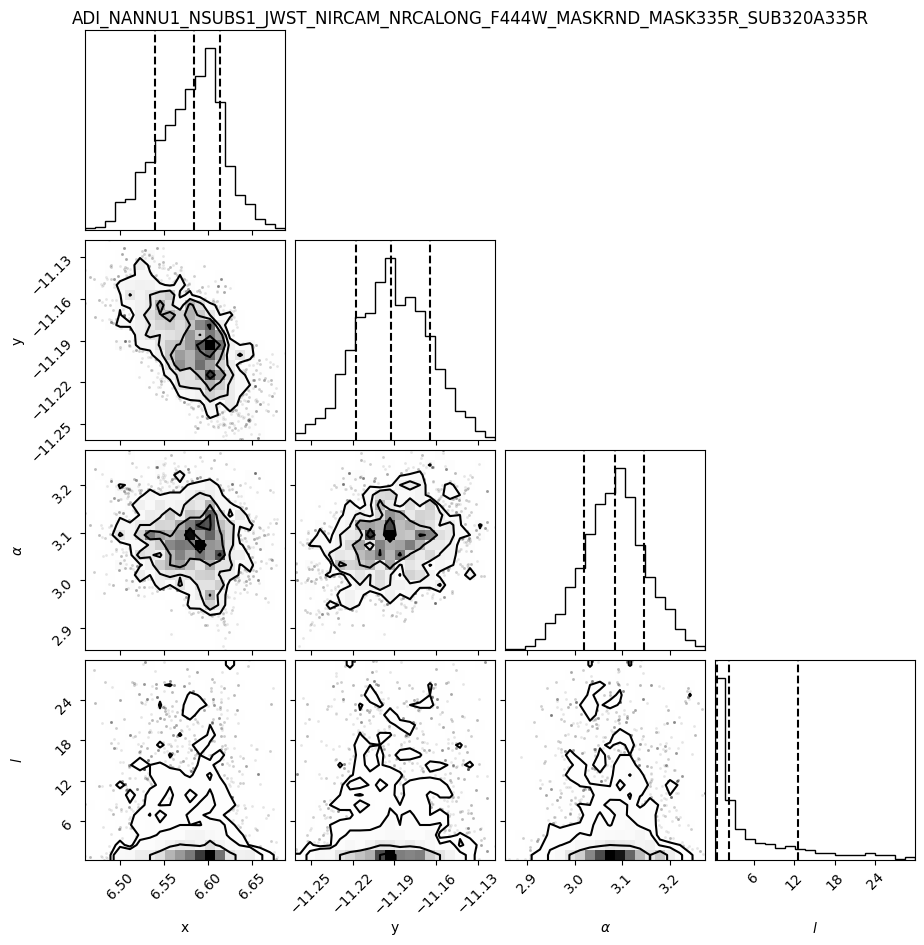

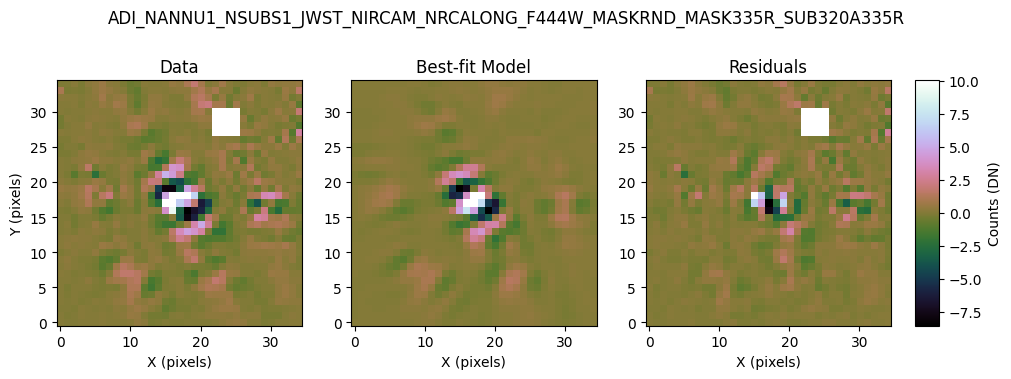

  0%|          | 0/1 [00:00<?, ?it/s]

Table saved to data_nircam_hd65426/companions/KL50/C1/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-results_c1.ecsv
[spaceKLIP.psf:INFO] Generating on-axis and off-axis PSFs...
[spaceKLIP.psf:INFO]   Done.
Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 723807.0352323258 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time


/Users/kglidic/miniconda3/envs/sklip_n/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)
/Users/kglidic/miniconda3/envs/sklip_n/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)
/Users/kglidic/miniconda3/envs/sklip_n/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)
/Users/kglidic/miniconda3/envs/sklip_n/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



Closing threadpool
Writing KLIPed Images to directory /System/Volumes/Data/user/kglidic/spaceKLIP/docs/source/tutorials/data_nircam_hd65426/companions/KL50/C1/KLIP_FM
Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished


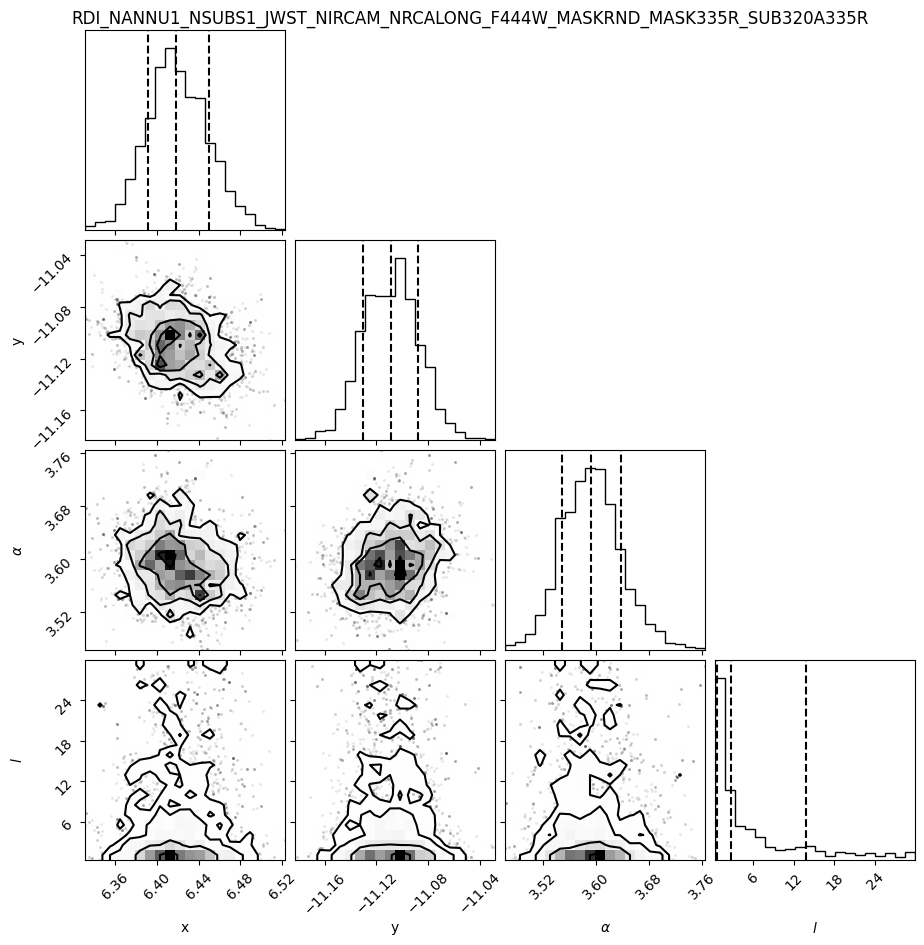

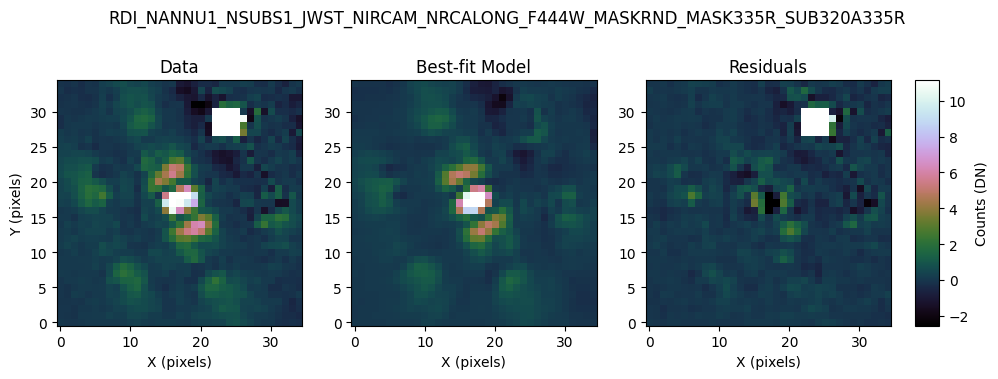

  0%|          | 0/1 [00:00<?, ?it/s]

Table saved to data_nircam_hd65426/companions/KL50/C1/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-results_c1.ecsv


In [20]:
# Extract companions.
analysistools.extract_companions(
    companions=[[comp_dra, comp_ddec, 1e-4]],  # Delta RA, Dec, contrast.
    starfile=star_photometry_vot,  # Stellar photometry.
    mstar_err=0.0,  # Stellar photometry uncertainty.
    spectral_type=star_spectral_type,  # Spectral type.
    highpass=False,  # Apply high-pass filter?
    remove_background=False,  # Remove a constant background level?
    use_fm_psf=True,  # Use FM PSF generated with pyKLIP?
    fitmethod='mcmc',  # Sampling algorithm.
    fitkernel='diag',  # Covariance kernel for GP regression.
    # KL mode for companion extraction.
    # If 'max', then the maximum possible KL mode will be used.
    klmode='max',
    # Grab observation date from FITS header to query for the wavefront
    # measurement closest in time to the given date.
    date='auto',
    subtract=True,  # Subtract each extracted companion before next fit.
    # Instead of fitting for a companion at guessed location/contrast,
    # inject one into the data.
    inject=False,
    save_preklip=False,  # Save stage 2 files when injecting/killing a companion?
    overwrite=True,  # Compute new FM PSF and overwrite any existing one?
    subdir='companions'  # Output subdirectory.
)

The output plots provide a visual summary of the model fitting process and the derived companion parameters, offering insight into the quality of the fit and the confidence in the measurements.

1. **Corner Plot (MCMC Results)**: This plot shows the parameter space explored during MCMC fitting. It includes the posterior probability distributions for each parameter (diagonal panels) and the correlations between pairs of parameters (off-diagonal panels), helping assess uncertainties, confidence intervals, and correlations.

    * **x**: The fitted x-offset of the companion in pixels from the center.
    * **y**: The fitted y-offset of the companion in pixels from the center.
    * **α**: The flux scaling factor matching the FM to the observed data.
    * **l**: The "length scale" hyperparameter of the Gaussian process covariance function. It determines the smoothness of the noise model; a larger **l** suggests slower noise variation, while a smaller **l** indicates rapid changes.

2. **Best Fit Model**: These plots illustrate the model PSF fit to the data. The three panels show:

    * **Observed Data**: The first panel displays the KLIP-subtracted data.
    * **Best Fit Model**: The second panel shows the FM PSF of the companion, refined through an iterative fitting process to match the observed data best.
    * **Residuals**: The third panel shows the differences between the observed data and the best-fit model. A flat residual plot indicates a good fit.

Let's take a look at one of the best-fit result tables. 

In [21]:
# Optional: open the saved PDF files.
!open data_nircam_hd65426/companions/KL50/C1/*pdf

In [22]:
# List the final result tables
!ls data_nircam_hd65426/companions/KL50/C1/*ecsv

data_nircam_hd65426/companions/KL50/C1/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-results_c1.ecsv
data_nircam_hd65426/companions/KL50/C1/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-results_c1.ecsv
data_nircam_hd65426/companions/KL50/C1/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-results_c1.ecsv


In [23]:
ecsv_tables = glob.glob('data_nircam_hd65426/companions/KL50/C1/*ecsv')
ecsv_table = astropy.table.Table.read(ecsv_tables[0], format='ascii.ecsv')
ecsv_table

ID,RA,RA_ERR,DEC,DEC_ERR,FLUX_JY,FLUX_JY_ERR,FLUX_SI,FLUX_SI_ERR,FLUX_SI_ALT,FLUX_SI_ALT_ERR,CON,CON_ERR,DELMAG,DELMAG_ERR,APPMAG,APPMAG_ERR,MSTAR,MSTAR_ERR,SNR,LN(Z/Z0),TP_CORONMSK,TP_COMSUBST,FITSFILE
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object
1,0.40064412902450736,0.0018402224283723294,-0.6934400305013785,0.0013410613729986712,0.00012813691848217635,1.5662150295647286e-06,1.980335306570319e-17,2.420559942808005e-19,1.9491977888521486e-17,2.382500616260114e-19,0.00035923974488155094,4.390980322573835e-06,8.611539051755553,0.013270932235437564,15.39346188594234,0.013270932235437564,6.781922834186787,0.0,31.154336673549967,nan,0.7620577147905852,0.9177125558769799,data_nircam_hd65426/companions/KL50/C1/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-fitpsf_c1.fits


---
The results obtained here can be directly compared to the [JWST Early Release Science (ERS) coronagraphic observations of the super-Jupiter exoplanet HIP 65426b](https://iopscience.iop.org/article/10.3847/2041-8213/acd93e), published by Aarynn Carter et al. Specifically, we find in the tutorial an absolute magnitude (relative to Vega) of 15.393±0.0133, compared to the paper's report of 15.467±0.078, consistent within 1-sigma of the tutorial values. Differences can be due to various updates in the JWST pipeline and the spaceKLIP algorithm. Additionally note that the ERS paper employs a different error analysis method. 

Congratulations on completing the analysis on HIP 65426 b with spaceKLIP!